# Example to handle groups of varibles with known causal orders btw the groups
The third group does not cause the first and second. The second group 
does not cause the first. This example estimates the causal structure of variables of the second group. Further, it estimates the causal structure of variables of the third group if all the variables of the third are continuous or the third group has only a binary variable.

## Import necessary packages

In [ ]:
import numpy as np
import pandas as pd
import graphviz
from sklearn.linear_model import LinearRegression, LogisticRegression
import lingam
from lingam.utils import make_dot, remove_effect, predict_adaptive_lasso

from IPython.display import display_svg, SVG

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

['1.16.2', '0.24.2', '0.11.1', '1.4.0']


In [ ]:
# Output setting
np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

## Indicate which variable belong to which group

In [ ]:
# Dataset to be analyzed
input_file = 'data1.csv'

# Indicate which variable belong to which group
set1_labels = ['x1_1', 'x1_2']
set2_labels = ['x2_1', 'x2_2', 'x2_3', 'x2_4', 'x2_5']
set3_labels = ['x3_1', 'x3_2', 'x3_3']
labels = set1_labels + set2_labels + set3_labels

## Load data

In [ ]:
X = pd.read_csv(input_file)

# Check if the third group includes a binary data
contain_bin_var_in_set3 = False
for set3_label in set3_labels:
    if len(np.unique(X[set3_label])) == 2:
        X[set3_label] = X[set3_label].astype(int)
        contain_bin_var_in_set3 = True

if contain_bin_var_in_set3:
    print('\x1b[31mThe third group includes a binary variable.\x1b[0m')

X.head()

,x1_1,x1_2,x2_1,x2_2,x2_3,x2_4,x2_5,x3_1,x3_2,x3_3
0,0.102727,0.205501,1.026972,-0.271038,-0.124869,-0.157580,0.273743,0.179777,0.048608,0.376362
1,0.562784,-3.905674,0.232378,2.365468,0.235710,-2.103891,0.458637,-0.603726,-0.053263,2.230408
2,0.230076,-0.049555,0.162457,0.885359,-1.226624,-2.974060,0.730431,-0.061475,0.883855,1.862853
3,0.094054,0.540496,-0.644040,0.962975,-0.615114,-1.208096,0.031687,1.125484,-0.864481,-1.166307
4,-0.165689,-2.430977,0.152987,2.184269,-2.179047,-2.949728,-1.430591,-6.400437,-2.622068,-1.654538


## Compute the residual when each variable of the second group on all the variables of the first group

In [ ]:
# Obtain the column numbers of the variables of the first group
set1_indices = [X.columns.get_loc(label) for label in set1_labels]

# Compute the residual when each variable of the second group on all the variables of the first group
X_removed_set1 = remove_effect(X, set1_indices)

# Create the residual dataset for the second group by the residuals computed just above
set2_indices = [X.columns.get_loc(label) for label in set2_labels]
X2_resid = X_removed_set1[:, set2_indices]

## Perform LiNGAM on the residual dataset for the second group and draw the estimated causal graph

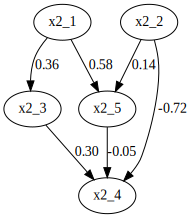

In [ ]:
set2_model = lingam.DirectLiNGAM()
set2_model.fit(X2_resid)
make_dot(set2_model.adjacency_matrix_, labels=set2_labels)

## Regress each variable of the third group on all the variables of the first and second groups

In [ ]:
if contain_bin_var_in_set3:
    print('\x1b[31mSkip because the third group includes a binary variable\x1b[0m')
else:
    # Obtain column numbers of the variables of the first and second groups
    set12_indices = [X.columns.get_loc(label) for label in set1_labels+set2_labels]

    # Regress each variable of the third group on all the variables of the first and second groups
    X_removed_set12 = remove_effect(X, set12_indices)

    # Create the residual dataset for the third group by the residuals computed just above
    set3_indices = [X.columns.get_loc(label) for label in set3_labels]
    X3_resid = X_removed_set12[:, set3_indices]

## Perform LiNGAM on the residual dataset for the third group and draw the estimated causal graph

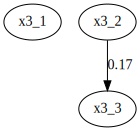

In [ ]:
if contain_bin_var_in_set3:
    print('\x1b[31mSkip because the third group includes a binary variableスキップします\x1b[0m')
else:
    set3_model = lingam.DirectLiNGAM()
    set3_model.fit(X3_resid)
    g = make_dot(set3_model.adjacency_matrix_, labels=set3_labels)
    display_svg(SVG(g._repr_svg_()))

## Combine the causal grpahs for the second and third groups and draw it

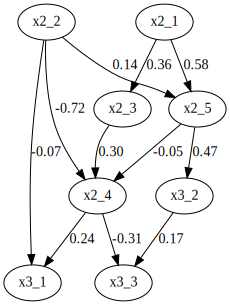

In [ ]:
if contain_bin_var_in_set3:
    print('\x1b[31mSkip because the third group includes a binary variable\x1b[0m')
else:
    # Adjucency matrix for the all the variables
    adj_matrix = np.zeros([X.shape[1], X.shape[1]])

    # Update the adjuncy matrix using the causal graph estimated for the second group
    set2_start_pos = len(set1_labels)
    set2_end_pos = set2_start_pos + len(set2_labels)
    adj_matrix[set2_start_pos:set2_end_pos, set2_start_pos:set2_end_pos] = set2_model.adjacency_matrix_

    # Update the adjuncy matrix using the causal graph estimated for the third group
    set3_start_pos = len(set1_labels) + len(set2_labels)
    set3_end_pos = set3_start_pos + len(set3_labels)
    adj_matrix[set3_start_pos:set3_end_pos, set3_start_pos:set3_end_pos] = set3_model.adjacency_matrix_

    # Compute the connection strengths from each variable of the second group to that of the third
    for i, idx in enumerate(set3_indices):

        # Obtain parents of each variable of the third group
        set3_parents = np.where(np.abs(set3_model.adjacency_matrix_[i]) > 0)[0]
        set3_parents = [X.columns.get_loc(set3_labels[idx]) for idx in set3_parents]

        # Create the set of explanatory variables
        predictors = []
        predictors.extend(set2_indices) # All the variables of the second group
        predictors.extend(set3_parents) # Parents in the third group

        # Pruning
        coefs = predict_adaptive_lasso(X_removed_set1, predictors, idx)
        adj_matrix[idx, set2_start_pos:set2_end_pos] = coefs[:len(set2_indices)]

    # Remove a part of the adjacency matrix corresponding the variables of the first group
    adj_matrix_set23 = adj_matrix[set2_start_pos:, set2_start_pos:]
    g = make_dot(adj_matrix_set23, labels=set2_labels+set3_labels)
    display_svg(SVG(g._repr_svg_()))

## Compute causal effects from each variable of the second group to that of the third

In [ ]:
# Compute causal effects from each variable of the second group to that of the third
for set3_label in set3_labels:
    for set2_label in set2_labels:

        # Create the variable index
        var2_index = X.columns.get_loc(set2_label)
        var3_index = X.columns.get_loc(set3_label)
        
        # Obtain parents of each variable of the second group
        parents = np.where(np.abs(set2_model.adjacency_matrix_[set2_labels.index(set2_label)]) > 0)[0]
        parents = [X.columns.get_loc(set2_labels[idx]) for idx in parents]

        # Create the set of explanatory variables
        predictors = [var2_index]
        predictors.extend(parents)
        predictors.extend(set1_indices)

        # If all the variables of the third group are continuous, peform linear regression
        # If they are binary, perform logistic regression
        if len(np.unique(X[set3_label])) != 2:
            lr = LinearRegression()
            lr.fit(X.iloc[:, predictors], X.iloc[:, var3_index])
            effect = lr.coef_[0]
        else:
            lr = LogisticRegression(solver='liblinear')
            lr.fit(X.iloc[:, predictors], X.iloc[:, var3_index])
            X_intervened = X.copy()
            X_intervened.iloc[:, var2_index] = X.iloc[:, var2_index].mean() # do(x=E(x))
            p1 = lr.predict_proba(X_intervened.iloc[:, predictors])
            X_intervened.iloc[:, var2_index] = X.iloc[:, var2_index].mean() + 1 # do(x=E(x)+1)
            p2 = lr.predict_proba(X_intervened.iloc[:, predictors])
            effect = p2[:, 1].mean() - p1[:, 1].mean() # The difference btw the two averages

        print(f'{set2_label} ---> {set3_label} : {effect:.3f}')

x2_1 ---> x3_1 : -0.004
x2_2 ---> x3_1 : -0.258
x2_3 ---> x3_1 : 0.085
x2_4 ---> x3_1 : 0.243
x2_5 ---> x3_1 : 0.000
x2_1 ---> x3_2 : 0.322
x2_2 ---> x3_2 : 0.112
x2_3 ---> x3_2 : -0.014
x2_4 ---> x3_2 : -0.045
x2_5 ---> x3_2 : 0.496
x2_1 ---> x3_3 : 0.054
x2_2 ---> x3_3 : 0.270
x2_3 ---> x3_3 : -0.085
x2_4 ---> x3_3 : -0.339
x2_5 ---> x3_3 : 0.121
